Vit ECG Image Classification Model

In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50

from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Preproccesing the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/ML /ecg_image_classification/ECG_Images",
    labels="inferred",
    label_mode="int",
    class_names=["ECG Images of Myocardial Infarction Patients (240x12=2880)",
                 "ECG Images of Patient that have abnormal heartbeat (233x12=2796)",
                 "ECG Images of Patient that have History of MI (172x12=2064)",
                 "Normal Person ECG Images (284x12=3408)"],
    color_mode="rgb",
    batch_size=32,
    image_size=(182, 256),
    shuffle=True,
    seed=2,
    validation_split=0.1,
    subset="both",
    interpolation="area",
    crop_to_aspect_ratio=True,
 )

Found 928 files belonging to 4 classes.
Using 836 files for training.
Using 92 files for validation.


In [53]:
def normalize(image, labels):
  """Normalize training/test set"""
  return (tf.cast(image, tf.float32)/255.0, labels)
norm_train_ds = train_ds.map(normalize)
norm_val_ds = val_ds.map(normalize)

In [69]:
# Verify the normalization
i_2 = norm_train_ds.as_numpy_iterator()
image, label = i_2.next()
print(f"Image Shape: {image.shape}, Label Shape: {label.shape}")

Image Shape: (32, 182, 256, 3), Label Shape: (32,)


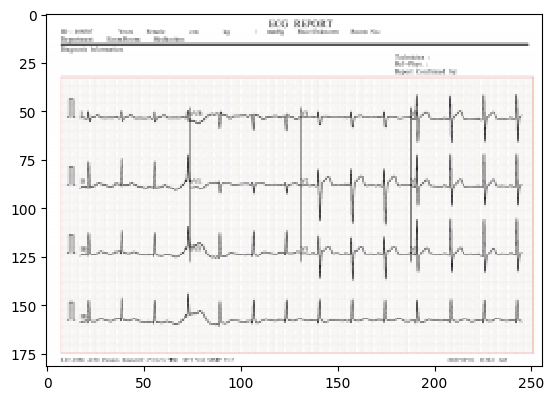

In [71]:
# Show the image to see if the resize algorithem keep the crucial information or not
plt.imshow(i_2.next()[0][0], interpolation="nearest")

In [56]:
def vit_block(x):
  """ Define the transformer layer blocks for vit model"""
  prenorm = x
  x = tf.keras.layers.LayerNormalization()(x) # Add pre self attention layer norm
  x = tf.keras.layers.MultiHeadAttention(num_heads=32, key_dim=16, value_dim=16)(x, x) # Make a self attention layer(with 4 heads)
  x = prenorm + x # Residual(Use it so model predictes only the changes insead of the whole information)
  prenorm2 = x # Store the output before normalization
  x = tf.keras.layers.LayerNormalization()(x) # Add pre mlp layer norm
  x = mlp_block(x) + prenorm2 # Residual
  return x

def mlp_block(x):
  """define multi layer perceptron(dense*relu*dense)"""
  x = tf.keras.layers.Dense(units=2048, activation="relu")(x)
  x = tf.keras.layers.Dense(units=512, activation=None)(x)
  return x


In [62]:
# Define the model's artitecture
input = tf.keras.Input(shape=(182, 256, 3)) # Define the input neorons
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(7, 8), strides=(7, 8))(input) # Patchify
x = tf.keras.layers.Reshape((26 * 32, 512))(x) # Flattening the inputs
# Add Positional information to the input because self attention is permutation invariant.
pos_emb = tf.keras.layers.Embedding(input_dim=26 * 32, output_dim=512)
pos_indices = tf.range(tf.shape(x)[1])
x = x + pos_emb(pos_indices)

for i in range(8): # Add vit blocks to the model
  x = vit_block(x)

x = tf.keras.layers.LayerNormalization()(x) # Final layer norm
# The magnitude of the residuals increase with the network depth, we need to do
# a finaal layer normalization to avoid really large activations here.

x = tf.keras.layers.GlobalAveragePooling1D()(x) # Reduction of spatial dimentions

x = tf.keras.layers.Dense(units=4, activation=None)(x) # final classification layer

model = tf.keras.Model(inputs=input, outputs=x) # Make the model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 182, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 26, 32, 512)          86528     ['input_6[0][0]']             
                                                                                                  
 reshape_5 (Reshape)         (None, 832, 512)             0         ['conv2d_5[0][0]']            
                                                                                                  
 tf.compat.v1.shape_5 (TFOp  (3,)                         0         ['reshape_5[0][0]']           
 Lambda)                                                                                    

In [63]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_2=.99, weight_decay=1e0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
              )

In [64]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/random bootcamp material/ecg_model_checkpoint/heart_model_checkpoint.h5',  # Specify the file to save the model
    save_best_only=False,            # Save only the best model
    monitor='val_loss',              # Monitor the validation loss
    mode='min',                      # Mode can be 'min' or 'max' depending on the monitored metric
    save_weights_only=False,         # Save the entire model, not just weights
    save_freq=5                      # Save every 5 epochs
)
model.fit(norm_train_ds, epochs=35, callbacks=checkpoint_callback) # Train the model

Epoch 1/35
27/27 [==============================] - 48s 758ms/step - loss: 2.5517 - sparse_categorical_accuracy: 0.2560
Epoch 2/35
27/27 [==============================] - 20s 722ms/step - loss: 1.4892 - sparse_categorical_accuracy: 0.2871
Epoch 3/35
27/27 [==============================] - 22s 730ms/step - loss: 1.4754 - sparse_categorical_accuracy: 0.2368
Epoch 4/35
27/27 [==============================] - 20s 712ms/step - loss: 1.4417 - sparse_categorical_accuracy: 0.2943
Epoch 5/35
27/27 [==============================] - 22s 779ms/step - loss: 1.4055 - sparse_categorical_accuracy: 0.2847
Epoch 6/35
27/27 [==============================] - 21s 717ms/step - loss: 1.4045 - sparse_categorical_accuracy: 0.2584
Epoch 7/35
27/27 [==============================] - 20s 725ms/step - loss: 1.4162 - sparse_categorical_accuracy: 0.2572
Epoch 8/35
27/27 [==============================] - 22s 720ms/step - loss: 1.4177 - sparse_categorical_accuracy: 0.2715
Epoch 9/35
27/27 [======================

In [65]:
# Evaluate the model on the test set
model.evaluate(norm_val_ds, verbose=2)

3/3 - 2s - loss: 0.4329 - sparse_categorical_accuracy: 0.8587 - 2s/epoch - 725ms/step


[0.4328712522983551, 0.8586956262588501]

In [66]:
# Evaluate the model on train set
model_loss, model_accuracy = model.evaluate(norm_train_ds, verbose= 2)

27/27 - 6s - loss: 0.1910 - sparse_categorical_accuracy: 0.9199 - 6s/epoch - 232ms/step


In [67]:
# Export the model
model.export("/content/drive/MyDrive/ML /ecg_image_classification/vit_ecg_model.hdf5")


Saved artifact at '/content/drive/MyDrive/ML /ecg_image_classification/vit_ecg_model.hdf5'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 182, 256, 3)
  Returns:
    float32 Tensor, shape=(None, 4)
